In [1]:
# ignore warnings
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
#imports
from pathlib import Path
import datetime as dt
import hvplot.pandas
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import geoviews as gv
import geoviews.feature as gf
from geoviews import dim, opts
import altair as alt
from vega_datasets import data
import scipy
from scipy import stats

In [3]:
# import CSVs
inflation_target_year_csv = Path("combined_inflation_cleaned_data.csv")
ibonds_csv = Path("ibonds_cleaned_data.csv")
cpi_csv = Path("cpi_cleaned_data.csv")


# create dfs
combined_df = pd.read_csv(inflation_target_year_csv)
ibonds_combined_df = pd.read_csv(ibonds_csv)
cpi_cpiu_data = pd.read_csv(cpi_csv)


# World Inflation Analyses

### Dot Map

calculations

In [4]:
# isolate 2022 in new df
inflation_target_year_df = combined_df[["latitude", "longitude", "2022"]]
# rename column for map
inflation_target_year_df.rename(columns={"2022":"Inflation Rate (2022)"}, inplace=True)
# drop nulls
inflation_target_year_df.dropna(inplace=True)

# calculate mean inflation overall during a specified time period
mean_world_inflation =  combined_df.iloc[:,-10:]

# find zscores to eliminate outliers that are skewing mean data (by country)
# for ease of masking, make absolute value
# attributed resouce: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.zscore.html
mean_world_inflation_zscores = abs(scipy.stats.zscore(mean_world_inflation, axis=1, nan_policy='omit'))

# mask dataframe based on zscore
# attributed resource: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mask.html
mean_world_inflation.mask(mean_world_inflation_zscores > 3, None, inplace=True)

# calculate mean
mean_world_inflation = mean_world_inflation.mean(axis=1, skipna=True)

# add to df
inflation_target_year_df["Mean Inflation"] = mean_world_inflation

# 2022 inflation as percentage of mean
inflation_target_year_df["2022 Inflation Rate Relative to 10-Year Mean Inflation"] = inflation_target_year_df["Inflation Rate (2022)"] / inflation_target_year_df["Mean Inflation"] * 100

display(inflation_target_year_df.head())

,latitude,longitude,Inflation Rate (2022),Mean Inflation,2022 Inflation Rate Relative to 10-Year Mean Inflation
1,41.153332,20.168331,6.725203,2.254846,298.255466
2,28.033886,1.659626,9.265516,4.807289,192.738884
6,17.060816,-61.796428,7.531078,1.791956,420.271357
8,40.069099,45.038189,8.640911,3.306948,261.295668
10,-25.274398,133.775136,6.594097,2.349890,280.613020


In [5]:
# describe last 20 years of inflation data
stats_df = inflation_target_year_df.iloc[:,-1]
summary_stats = stats_df.describe(include="all")
print(summary_stats)

# fine outliers visually
inflation_target_year_df["2022 Inflation Rate Relative to 10-Year Mean Inflation"].hvplot.box(ylim=(0,1000))

count     163.000000
mean      356.631191
std       548.986807
min        38.215381
25%       174.164405
50%       268.409884
75%       432.936831
max      6839.405508
Name: 2022 Inflation Rate Relative to 10-Year Mean Inflation, dtype: float64


:BoxWhisker   (2022 Inflation Rate Relative to 10-Year Mean Inflation)

data visualization

In [6]:

map = inflation_target_year_df.hvplot.points(
    "longitude",
    "latitude",
    geo=True,
    tiles="CartoLight",
    xlabel="longitude",
    ylabel="latitude",
    color="2022 Inflation Rate Relative to 10-Year Mean Inflation",
    clim=(0,800),
    frame_width=800,
    frame_height=400,
    cmap=["#b3f0ff", "#ffffff", "#ffd6cc", "#ff9980", "#ff3300", "#cc2900", "#801a00", "#330a00"],
    line_color="black",
    title="2022 Inflation Rate, Expressed as Percentage of 10-Year Mean",
    hover_cols=["country", "Inflation Rate (2022)"]
)

hvplot.save(map, "high_inflation_world_map.html")

map

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [longitude,latitude]   (2022 Inflation Rate Relative to 10-Year Mean Inflation,Inflation Rate (2022))

### Heatmap for World Inflation (Percent Change) 1960-2022

calculations

In [7]:
# preview dataframe
display(combined_df.head())

# this automatically changes the df from wide to long
pct_change_world_inflation_df = combined_df

# drop lat/lon
pct_change_world_inflation_df.drop(columns=["latitude", "longitude"], inplace=True)

# limit to ten years
pct_change_world_inflation_df = pct_change_world_inflation_df.iloc[:, -10:]

# find zscores to eliminate outliers that are skewing mean data (by year)
# for ease of masking, make absolute value
# attributed resouce: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.zscore.html
pct_change_world_inflation_df_zscores = abs(scipy.stats.zscore(pct_change_world_inflation_df, axis=0, nan_policy='omit'))

# mask dataframe based on zscore
# attributed resource: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mask.html
pct_change_world_inflation_df.mask(pct_change_world_inflation_df_zscores > 3, None, inplace=True)

# calculate mean by year
pct_change_world_inflation_df = pct_change_world_inflation_df.mean()

# change array to df
pct_change_world_inflation_df = pd.DataFrame(pct_change_world_inflation_df)

# name columns
pct_change_world_inflation_df.columns = ["percent change in inflation rate"]

# rename index
pct_change_world_inflation_df.rename_axis("year", inplace=True)

# reset index
pct_change_world_inflation_df.reset_index(inplace=True)

# preview df
display(pct_change_world_inflation_df.head())

,country,latitude,longitude,1960,1961,1962,1963,1964,1965,1966,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Afghanistan,33.939110,67.709953,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.385772,4.673996,-0.661709,4.383892,4.975952,0.626149,2.302373,NaN,NaN,NaN
1,Albania,41.153332,20.168331,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.937621,1.625865,1.896174,1.275432,1.986661,2.028060,1.411091,1.620887,2.041472,6.725203
2,Algeria,28.033886,1.659626,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.254239,2.916927,4.784447,6.397695,5.591116,4.269990,1.951768,2.415131,7.226063,9.265516
3,American Samoa,-14.270972,-170.132217,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Andorra,42.546245,1.601554,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,year,percent change in inflation rate
0,2013,3.596331
1,2014,3.262359
2,2015,2.819723
3,2016,3.616944
4,2017,3.489505


,percent change in inflation rate
count,10.000000
mean,4.327162
std,2.215846
min,2.819723
25%,3.392630
50%,3.554264
75%,3.708786
max,10.285945


<Axes: >

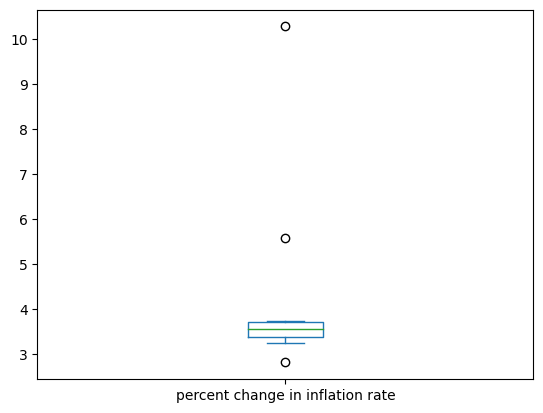

In [8]:
display(pct_change_world_inflation_df.describe())
pct_change_world_inflation_df.plot.box()

heatmap

In [9]:
# attributed resource: https://altair-viz.github.io/gallery/simple_heatmap.html

# create df with necessary data
heatmap_df = pct_change_world_inflation_df

# preview df
display(heatmap_df.head())

# advice from VS error on large datasets 
alt.data_transformers.enable("vegafusion")

# Configure heatmap
base = alt.Chart(heatmap_df, title="Aggregate Inflation Rate Worldwide 2013-2022").encode(
    x="year",
    y="percent change in inflation rate",
)

heatmap = base.mark_rect().encode(
    alt.Color("percent change in inflation rate", title=None)
    # scheme must be vega: https://vega.github.io/vega/docs/schemes/
        .scale(domain=[0, 15],scheme="yelloworangered")
)

# Configure text
text = base.mark_text(baseline="middle").encode(
    alt.Text("percent change in inflation rate", format=".2f"),
    color=alt.condition(
        alt.datum["percent change in inflation rate"],
        alt.value('black'),
        alt.value('black')
    )
)


# Draw the chart
heatmap + text.properties(
    width=800,
    height=400)


,year,percent change in inflation rate
0,2013,3.596331
1,2014,3.262359
2,2015,2.819723
3,2016,3.616944
4,2017,3.489505


alt.LayerChart(...)

# Consumer Price Index Analysis

line graph

In [10]:
cpi_plot = cpi_cpiu_data.hvplot(
    x="Label",
    y="Value",
    xticks="Year",
    title="USA Inflation Rate: Consumer Price Index for All Urban Consumers (CPI-U)",
    xlabel="year",
    ylabel="consumer price index",
    color="red",
    width=800,
    height=400
    
    
)

# save as html
hvplot.save(cpi_plot, "inflation_cpiu.html")

cpi_plot

:Curve   [Label]   (Value)

# I Bonds Analysis

### graphs

calculations

In [11]:
# annualize variable interest rate
ibonds_combined_df["annualized six-month variable interest rate"] = np.maximum((ibonds_combined_df["six-month inflation rate"] * 2), 0)

# combined rate
ibonds_combined_df["aggregate annualized interest rate"] = ibonds_combined_df["annualized six-month variable interest rate"] + ibonds_combined_df["fixed rate"]

ibonds_combined_df.head()

,date,fixed rate,six-month inflation rate,annualized six-month variable interest rate,aggregate annualized interest rate
0,09-1998,3.4,0.62,1.24,4.64
1,11-1998,3.3,0.86,1.72,5.02
2,05-1999,3.3,0.86,1.72,5.02
3,11-1999,3.4,1.76,3.52,6.92
4,05-2000,3.6,1.91,3.82,7.42


stacked bar chart

In [12]:
ibonds_bar = ibonds_combined_df.hvplot.bar(
    x="date",
    y=["fixed rate", "annualized six-month variable interest rate"],
    # set ylim to zero because interest cannot be negative on ibonds
    ylim=(0,12),
    stacked=True,
    color=["orange", "red"],
    title="I bonds Aggregate Annualized Interest Rate",
    ylabel="interest rate",
    rot=70,
    xlabel="",
    height=500,
    width=1200
    )

hvplot.save(ibonds_bar, "ibonds_bar.html")

ibonds_bar



:Bars   [date,Variable]   (value)